## Importing necessary libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler,SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression


# Data analysis and preprocess

In [2]:
# reading data from csv file
df = pd.read_csv('geram18.csv')
df

,Open,Minimum,Maximum,Close,Date,Position
0,"34,357,000","34,316,000","34,865,000","34,487,000",2024/05/02,High
1,"34,600,000","34,013,000","34,600,000","34,371,000",2024/05/01,Low
2,"34,985,000","34,371,000","35,777,000","34,570,000",2024/04/30,Low
3,"33,263,000","33,240,000","35,216,000","35,004,000",2024/04/29,High
4,"34,369,000","33,132,000","34,501,000","33,265,000",2024/04/28,Low
...,...,...,...,...,...,...
3381,"1,040,000","1,040,000","1,040,000","1,040,000",2013/07/27,High
3382,"1,030,000","1,030,000","1,030,000","1,030,000",2013/07/26,High
3383,"1,020,000","1,020,000","1,020,000","1,020,000",2013/07/24,Low
3384,"1,030,000","1,030,000","1,030,000","1,030,000",2013/07/23,High


In [3]:
# adding mean price item to df
df['Open']=df['Open'].str.replace(',' , '').astype('float')
df['Close']=df['Close'].str.replace(',' , '').astype('float')
df['Mean-Price'] = (df['Open'] + df['Close']) / 2
df

,Open,Minimum,Maximum,Close,Date,Position,Mean-Price
0,34357000.0,"34,316,000","34,865,000",34487000.0,2024/05/02,High,34422000.0
1,34600000.0,"34,013,000","34,600,000",34371000.0,2024/05/01,Low,34485500.0
2,34985000.0,"34,371,000","35,777,000",34570000.0,2024/04/30,Low,34777500.0
3,33263000.0,"33,240,000","35,216,000",35004000.0,2024/04/29,High,34133500.0
4,34369000.0,"33,132,000","34,501,000",33265000.0,2024/04/28,Low,33817000.0
...,...,...,...,...,...,...,...
3381,1040000.0,"1,040,000","1,040,000",1040000.0,2013/07/27,High,1040000.0
3382,1030000.0,"1,030,000","1,030,000",1030000.0,2013/07/26,High,1030000.0
3383,1020000.0,"1,020,000","1,020,000",1020000.0,2013/07/24,Low,1020000.0
3384,1030000.0,"1,030,000","1,030,000",1030000.0,2013/07/23,High,1030000.0


In [4]:
#cleaning df and changing the format of datetime to days  
df.drop(['Open'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
df.drop(['Minimum'], axis=1, inplace=True)
df.drop(['Maximum'], axis=1, inplace=True)
df.drop(['Position'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df['days'] = (df['Date'] - df['Date'].min()).dt.days
df

,Date,Mean-Price,days
0,2024-05-02,34422000.0,3937
1,2024-05-01,34485500.0,3936
2,2024-04-30,34777500.0,3935
3,2024-04-29,34133500.0,3934
4,2024-04-28,33817000.0,3933
...,...,...,...
3381,2013-07-27,1040000.0,5
3382,2013-07-26,1030000.0,4
3383,2013-07-24,1020000.0,2
3384,2013-07-23,1030000.0,1


In [5]:
#spliting data to train and test
X = df[["days"]]
y = df["Mean-Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Making a global class for regression models and optimization with Optuna

In [6]:
# making a global class for models and optuna optimization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import optuna
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    median_absolute_error
)
from sklearn.model_selection import cross_val_score

class RegressionModelOptunaSearch:
    
    def __init__(self, model_callback, n_trials=50):
        self.model_callback = model_callback
        self.n_trials = n_trials
        self.best_model_ = None
        self.best_params_ = None

# metrics evaluation for both train and test
    def additional_scores(self, y_true, y_pred):
        scores = {
            'Mean Absolute Error (MAE)': mean_absolute_error(y_true, y_pred),
            'Mean Squared Error (MSE)': mean_squared_error(y_true, y_pred),
            'Root Mean Squared Error (RMSE)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'Mean Absolute Percentage Error (MAPE)': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
            'Median Absolute Error (MedAE)': median_absolute_error(y_true, y_pred),
        }
        return scores
# ploting a graph for each model after optimization
    def plot_actual_vs_fitted(self, best_model, X_val, y_val, model_name="Model"):
        X_val_sorted = X_val.sort_values(by="days", ascending=False)
        y_pred = best_model.predict(X_val_sorted)
        y_test_sorted = y_val.sort_values(ascending=False)
        y_pred_sorted = y_pred
        start_date = pd.to_datetime("2013-07-22")
        real_dates = start_date + pd.to_timedelta(X_val_sorted['days'], unit='D')

        plt.figure(figsize=(10, 6))
        plt.scatter(real_dates, y_test_sorted, color='navy', alpha=0.6, label='Actual values')
        plt.plot(real_dates, y_pred_sorted, color='darkred', linewidth=2, label='Fitted values')
        plt.title(f'Actual vs Fitted Values: {model_name}')
        plt.xlabel('Years')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
# train and test function
    def fit_and_score(self, X_train, y_train, X_val, y_val, score=True, show_fit_plot=True):
        def objective(trial):
            model = self.model_callback(trial)
            score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
            return score.mean()
# optimizing model with Optuna 
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)

        self.best_params_ = study.best_trial.params
        print("Best Parameters:", self.best_params_, '\n')

        # Recreate the best model from the best trial
        self.best_model_ = self.model_callback(optuna.trial.FixedTrial(self.best_params_))
        self.best_model_.fit(X_train, y_train)

        y_pred_train = self.best_model_.predict(X_train)
        print(f"R² Score on train set is {r2_score(y_train, y_pred_train)} \n")

        y_pred_valid = self.best_model_.predict(X_val)
        print(f"R² Score on validation set is {r2_score(y_val, y_pred_valid)} \n")

        if score:
            additional_scores_train = self.additional_scores(y_train, y_pred_train)
            additional_scores_val = self.additional_scores(y_val, y_pred_valid)

            print("Additional Scores for Training Set:\n")
            for score_name, score_value in additional_scores_train.items():
                print(f"{score_name}: {score_value}")

            print("\nAdditional Scores for Validation Set:")
            for score_name, score_value in additional_scores_val.items():
                print(f"{score_name}: {score_value}")

        if show_fit_plot:
            self.plot_actual_vs_fitted(self.best_model_, X_val, y_val, model_name="BestModel")

        return self.additional_scores(y_val, y_pred_valid)



c:\Users\Kian\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# creating a list for the metric scores for each mode
scores = []

# OSL regression

[I 2025-06-11 19:51:43,809] A new study created in memory with name: no-name-67e35342-5b8c-4c33-8b7a-88b535db7636
[I 2025-06-11 19:51:43,840] Trial 0 finished with value: -15522457690438.006 and parameters: {}. Best is trial 0 with value: -15522457690438.006.
[I 2025-06-11 19:51:43,859] Trial 1 finished with value: -15522457690438.006 and parameters: {}. Best is trial 0 with value: -15522457690438.006.
[I 2025-06-11 19:51:43,876] Trial 2 finished with value: -15522457690438.006 and parameters: {}. Best is trial 0 with value: -15522457690438.006.
[I 2025-06-11 19:51:43,892] Trial 3 finished with value: -15522457690438.006 and parameters: {}. Best is trial 0 with value: -15522457690438.006.
[I 2025-06-11 19:51:43,911] Trial 4 finished with value: -15522457690438.006 and parameters: {}. Best is trial 0 with value: -15522457690438.006.
[I 2025-06-11 19:51:43,929] Trial 5 finished with value: -15522457690438.006 and parameters: {}. Best is trial 0 with value: -15522457690438.006.
[I 2025-06

Best Parameters: {} 

R² Score on train set is 0.7536118708104974 

R² Score on validation set is 0.7720742879929843 

Additional Scores for Training Set:

Mean Absolute Error (MAE): 3154878.1030932534
Mean Squared Error (MSE): 15485194968649.879
Root Mean Squared Error (RMSE): 3935123.246945371
Mean Absolute Percentage Error (MAPE): 134.71391106524396
Median Absolute Error (MedAE): 2885205.23458165

Additional Scores for Validation Set:
Mean Absolute Error (MAE): 3348698.0993431187
Mean Squared Error (MSE): 17826591080187.176
Root Mean Squared Error (RMSE): 4222154.791121137
Mean Absolute Percentage Error (MAPE): 129.27478427098998
Median Absolute Error (MedAE): 2879276.0209166054


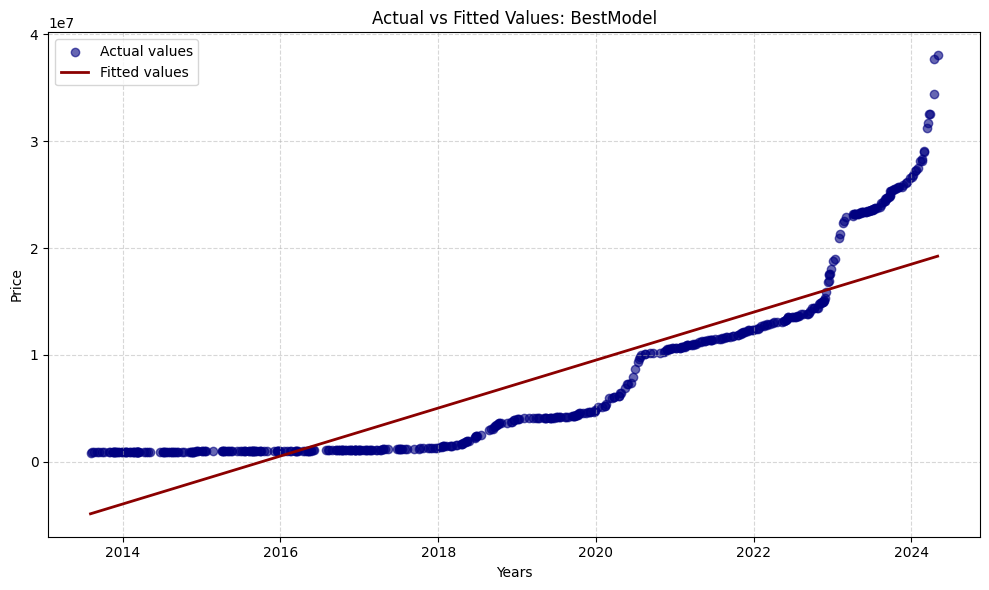

In [8]:
def suggest_pipeline(trial):
    model = Pipeline([
        ("regressor", LinearRegression()),
    ])
    return model

optuna_search = RegressionModelOptunaSearch( suggest_pipeline, n_trials=100)
score = optuna_search.fit_and_score(X_train, y_train, X_test, y_test)
scores.append(score)

# Lasso regression

[I 2025-06-11 19:51:46,127] A new study created in memory with name: no-name-89979a17-81dd-4eae-bd09-ba77769746c1
[I 2025-06-11 19:51:46,189] Trial 0 finished with value: -15522457690438.078 and parameters: {'alpha': 0.0003793218734652818, 'max_iter': 8524}. Best is trial 0 with value: -15522457690438.078.
[I 2025-06-11 19:51:46,213] Trial 1 finished with value: -15522457691270.16 and parameters: {'alpha': 4.408243405706868, 'max_iter': 4733}. Best is trial 0 with value: -15522457690438.078.
[I 2025-06-11 19:51:46,244] Trial 2 finished with value: -15522457690466.938 and parameters: {'alpha': 0.15679460792764627, 'max_iter': 1661}. Best is trial 0 with value: -15522457690438.078.
[I 2025-06-11 19:51:46,276] Trial 3 finished with value: -15522457691149.172 and parameters: {'alpha': 3.779897161366523, 'max_iter': 230}. Best is trial 0 with value: -15522457690438.078.
[I 2025-06-11 19:51:46,311] Trial 4 finished with value: -15522457691393.37 and parameters: {'alpha': 5.043914906460011, '

Best Parameters: {'alpha': 0.00010677240047699742, 'max_iter': 41347} 

R² Score on train set is 0.7536118708104974 

R² Score on validation set is 0.772074287991394 

Additional Scores for Training Set:

Mean Absolute Error (MAE): 3154878.103065736
Mean Squared Error (MSE): 15485194968649.879
Root Mean Squared Error (RMSE): 3935123.246945371
Mean Absolute Percentage Error (MAPE): 134.71391106259145
Median Absolute Error (MedAE): 2885205.234535415

Additional Scores for Validation Set:
Mean Absolute Error (MAE): 3348698.099322921
Mean Squared Error (MSE): 17826591080311.56
Root Mean Squared Error (RMSE): 4222154.791135867
Mean Absolute Percentage Error (MAPE): 129.27478426822964
Median Absolute Error (MedAE): 2879276.0207749372


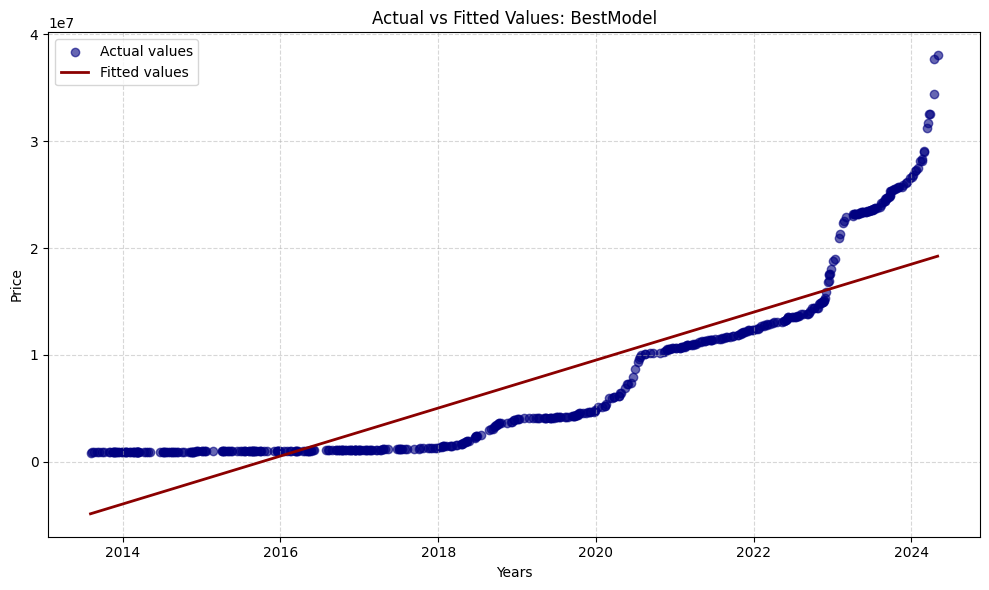

In [9]:
# hyper parameters and model justification
def suggest_pipeline(trial):
    alpha = trial.suggest_float("alpha", 0.0001, 10.0, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 100000, log=True)
    model = Pipeline([
        ("normalizer", StandardScaler()),
        ("regressor", Lasso(alpha=alpha, max_iter=max_iter)),
    ])
    return model

optuna_search = RegressionModelOptunaSearch( suggest_pipeline, n_trials=100)
score = optuna_search.fit_and_score(X_train, y_train, X_test, y_test)
scores.append(score)

# Ridge regression

[I 2025-06-11 19:51:50,181] A new study created in memory with name: no-name-7042bda2-e8f3-4fbf-919d-d3fd4b628920
[I 2025-06-11 19:51:50,234] Trial 0 finished with value: -15522457623313.65 and parameters: {'alpha': 0.004791427338760316, 'max_iter': 669}. Best is trial 0 with value: -15522457623313.65.
[I 2025-06-11 19:51:50,265] Trial 1 finished with value: -15542477178618.088 and parameters: {'alpha': 49.145786269341215, 'max_iter': 1675}. Best is trial 0 with value: -15522457623313.65.
[I 2025-06-11 19:51:50,294] Trial 2 finished with value: -15597810060699.584 and parameters: {'alpha': 96.48716533527241, 'max_iter': 13422}. Best is trial 0 with value: -15522457623313.65.
[I 2025-06-11 19:51:50,318] Trial 3 finished with value: -15522457690242.475 and parameters: {'alpha': 1.391477134409783e-05, 'max_iter': 468}. Best is trial 0 with value: -15522457623313.65.
[I 2025-06-11 19:51:50,348] Trial 4 finished with value: -22532763450178.965 and parameters: {'alpha': 1441.2640635615708, '

Best Parameters: {'alpha': 0.792348948827835, 'max_iter': 47063} 

R² Score on train set is 0.7536118137204999 

R² Score on validation set is 0.7720460232935573 

Additional Scores for Training Set:

Mean Absolute Error (MAE): 3154389.924153579
Mean Squared Error (MSE): 15485198556686.951
Root Mean Squared Error (RMSE): 3935123.7028442896
Mean Absolute Percentage Error (MAPE): 134.6668545136527
Median Absolute Error (MedAE): 2884385.0150710028

Additional Scores for Validation Set:
Mean Absolute Error (MAE): 3348339.794059397
Mean Squared Error (MSE): 17828801726955.6
Root Mean Squared Error (RMSE): 4222416.57430382
Mean Absolute Percentage Error (MAPE): 129.2258138802971
Median Absolute Error (MedAE): 2876762.7761499463


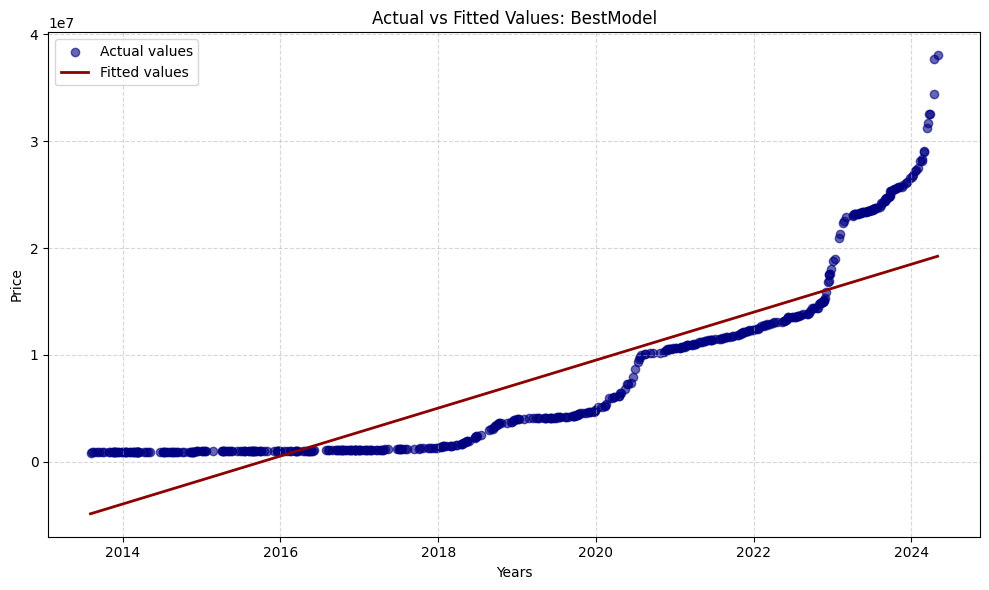

In [10]:
# hyper parameters and model justification
def suggest_pipeline(trial):
    alpha = trial.suggest_float("alpha", 0.00001, 10000000.0, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 100000, log=True)
    model = Pipeline([
        ("normalizer", StandardScaler()),
        ("regressor", Ridge(alpha=alpha, max_iter=max_iter)),
    ])
    return model

optuna_search = RegressionModelOptunaSearch( suggest_pipeline, n_trials=100)
score = optuna_search.fit_and_score(X_train, y_train, X_test, y_test)
scores.append(score)

# B-spline regression

[I 2025-06-11 19:51:54,011] A new study created in memory with name: no-name-2d223507-bccb-46b7-bf04-3e788fd689e0
[I 2025-06-11 19:51:54,105] Trial 0 finished with value: -221329155572.43353 and parameters: {'degree': 1, 'n_knots': 42}. Best is trial 0 with value: -221329155572.43353.
[I 2025-06-11 19:51:54,147] Trial 1 finished with value: -884475260134.1715 and parameters: {'degree': 3, 'n_knots': 13}. Best is trial 0 with value: -221329155572.43353.
[I 2025-06-11 19:51:54,217] Trial 2 finished with value: -171740614899.77164 and parameters: {'degree': 4, 'n_knots': 48}. Best is trial 2 with value: -171740614899.77164.
[I 2025-06-11 19:51:54,311] Trial 3 finished with value: -151487324193.97 and parameters: {'degree': 4, 'n_knots': 63}. Best is trial 3 with value: -151487324193.97.
[I 2025-06-11 19:51:54,344] Trial 4 finished with value: -1435203748821.5786 and parameters: {'degree': 1, 'n_knots': 14}. Best is trial 3 with value: -151487324193.97.
[I 2025-06-11 19:51:54,568] Trial 5 

Best Parameters: {'degree': 2, 'n_knots': 526} 

R² Score on train set is 0.9997043273156742 

R² Score on validation set is 0.9997477113279636 

Additional Scores for Training Set:

Mean Absolute Error (MAE): 60276.19404146709
Mean Squared Error (MSE): 18582669460.382267
Root Mean Squared Error (RMSE): 136318.26532193794
Mean Absolute Percentage Error (MAPE): 0.7109457514489539
Median Absolute Error (MedAE): 13453.427461648826

Additional Scores for Validation Set:
Mean Absolute Error (MAE): 73465.23066044039
Mean Squared Error (MSE): 19732073889.13668
Root Mean Squared Error (RMSE): 140470.90050660557
Mean Absolute Percentage Error (MAPE): 0.8324604704609422
Median Absolute Error (MedAE): 19788.901357382536


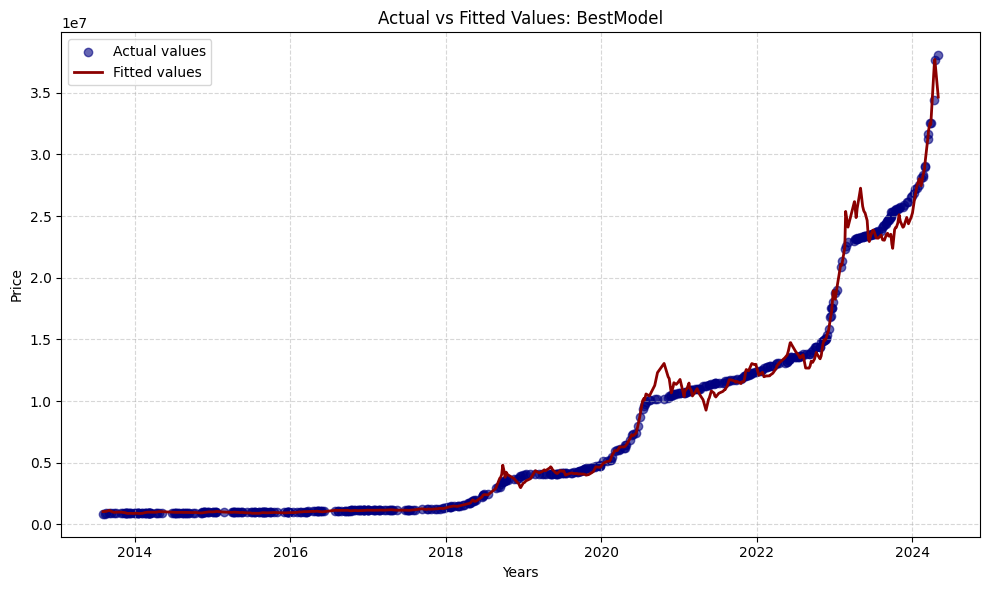

In [11]:
# hyper parameters and model justification
def suggest_pipeline(trial):
    degree = trial.suggest_int("degree", 1, 4)
    n_knots = trial.suggest_int("n_knots", 10,1500, log=True)
    model = Pipeline([
        ("spline_transformer", SplineTransformer(n_knots=n_knots, degree=degree)),
        ("regressor", LinearRegression())
    ])
    return model

optuna_search = RegressionModelOptunaSearch( suggest_pipeline, n_trials=100)
score = optuna_search.fit_and_score(X_train, y_train, X_test, y_test)
scores.append(score)

# P-spline regression with zero-order penalty(Ridge)

[I 2025-06-11 19:54:44,713] A new study created in memory with name: no-name-6683c793-75b0-41f5-b7df-58b67d937d4f
[I 2025-06-11 19:54:44,789] Trial 0 finished with value: -197330689438.64154 and parameters: {'degree': 1, 'n_knots': 46, 'alpha': 0.10076743068801043, 'max_iter': 49220}. Best is trial 0 with value: -197330689438.64154.
[I 2025-06-11 19:54:45,109] Trial 1 finished with value: -512015224085.22034 and parameters: {'degree': 3, 'n_knots': 572, 'alpha': 0.25539465309393883, 'max_iter': 77197}. Best is trial 0 with value: -197330689438.64154.
[I 2025-06-11 19:54:45,245] Trial 2 finished with value: -70881906025.86935 and parameters: {'degree': 3, 'n_knots': 299, 'alpha': 0.0664294544418537, 'max_iter': 701}. Best is trial 2 with value: -70881906025.86935.
[I 2025-06-11 19:54:45,593] Trial 3 finished with value: -60066093036026.016 and parameters: {'degree': 1, 'n_knots': 625, 'alpha': 134.01354497733183, 'max_iter': 75918}. Best is trial 2 with value: -70881906025.86935.
[I 202

Best Parameters: {'degree': 1, 'n_knots': 594, 'alpha': 3.4060012261647605e-05, 'max_iter': 551} 

R² Score on train set is 0.9997441834910968 

R² Score on validation set is 0.9996980110982848 

Additional Scores for Training Set:

Mean Absolute Error (MAE): 55900.97626833654
Mean Squared Error (MSE): 16077757193.88718
Root Mean Squared Error (RMSE): 126798.09617611449
Mean Absolute Percentage Error (MAPE): 0.669437672223005
Median Absolute Error (MedAE): 12625.360740529606

Additional Scores for Validation Set:
Mean Absolute Error (MAE): 76782.97235113764
Mean Squared Error (MSE): 23619242490.139034
Root Mean Squared Error (RMSE): 153685.53116718255
Mean Absolute Percentage Error (MAPE): 0.8418113138251544
Median Absolute Error (MedAE): 19505.61068103602


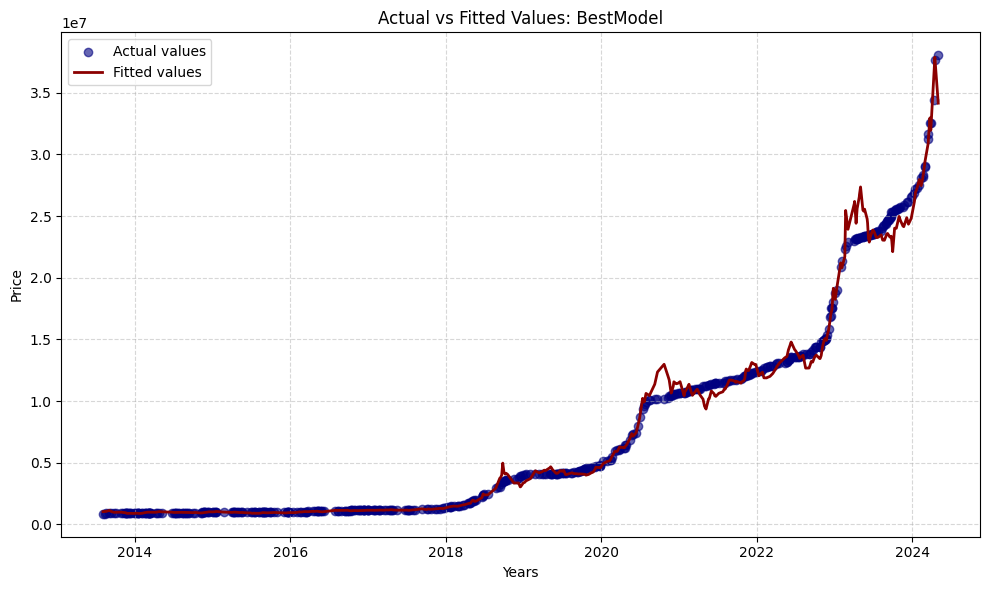

In [12]:
# hyper parameters and model justification
def suggest_pipeline(trial):
    degree = trial.suggest_int("degree", 1, 4)
    n_knots = trial.suggest_int("n_knots", 10,1500, log=True)
    alpha = trial.suggest_float("alpha", 0.00001, 10000000.0, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 100000, log=True)
    model = Pipeline([
        ("normalizer", StandardScaler()),
        ("spline_transformer", SplineTransformer(n_knots=n_knots, degree=degree)),
        ("regressor", Ridge(alpha=alpha, max_iter=max_iter))
    ])
    return model

optuna_search = RegressionModelOptunaSearch( suggest_pipeline, n_trials=100)
score = optuna_search.fit_and_score(X_train, y_train, X_test, y_test)
scores.append(score)

# Gradient Boosting regression

[I 2025-06-11 19:55:19,978] A new study created in memory with name: no-name-55568800-ff81-4a50-b5ba-76e115fc22ab
[I 2025-06-11 19:55:20,723] Trial 0 finished with value: -56913954696200.44 and parameters: {'n_estimator': 24, 'max_depth': 16, 'a': 0.002073633555323268}. Best is trial 0 with value: -56913954696200.44.
[I 2025-06-11 19:55:22,387] Trial 1 finished with value: -62488542457091.56 and parameters: {'n_estimator': 52, 'max_depth': 18, 'a': 5.892722543298565e-05}. Best is trial 0 with value: -56913954696200.44.
[I 2025-06-11 19:55:22,957] Trial 2 finished with value: -1541580205788.0596 and parameters: {'n_estimator': 41, 'max_depth': 6, 'a': 0.04490977202485503}. Best is trial 2 with value: -1541580205788.0596.
[I 2025-06-11 19:55:23,676] Trial 3 finished with value: -62776289637355.3 and parameters: {'n_estimator': 61, 'max_depth': 5, 'a': 1.2601214927580873e-05}. Best is trial 2 with value: -1541580205788.0596.
[I 2025-06-11 19:55:24,612] Trial 4 finished with value: -271740

Best Parameters: {'n_estimator': 71, 'max_depth': 7, 'a': 0.09936038120378299} 

R² Score on train set is 0.9999531961529196 

R² Score on validation set is 0.9996106308490745 

Additional Scores for Training Set:

Mean Absolute Error (MAE): 28492.620718262096
Mean Squared Error (MSE): 2941565000.33888
Root Mean Squared Error (RMSE): 54236.19640368303
Mean Absolute Percentage Error (MAPE): 0.5572836404103303
Median Absolute Error (MedAE): 10884.043343444762

Additional Scores for Validation Set:
Mean Absolute Error (MAE): 75202.23086811198
Mean Squared Error (MSE): 30453451572.738697
Root Mean Squared Error (RMSE): 174509.17331973897
Mean Absolute Percentage Error (MAPE): 0.9600037777474144
Median Absolute Error (MedAE): 23248.89758001431


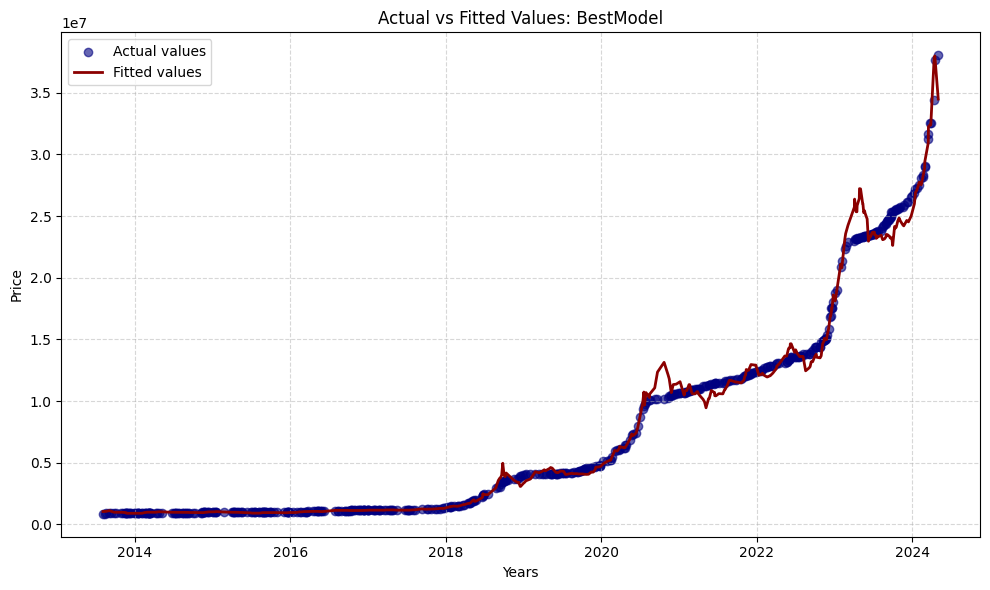

In [13]:
# hyper parameters and model justification
def suggest_pipeline(trial):
    n_estimator = trial.suggest_int("n_estimator", 10, 80)
    max_depth = trial.suggest_int("max_depth", 1, 20)
    a = trial.suggest_float("a", 0.00001, 0.1, log=True) 
    model = Pipeline([
        ("normalizer", StandardScaler()),
        ("regressor", GradientBoostingRegressor(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=a,)),
    ])
    return model

optuna_search = RegressionModelOptunaSearch( suggest_pipeline, n_trials=100)
score = optuna_search.fit_and_score(X_train, y_train, X_test, y_test)
scores.append(score)

# Metric results and scores

C:\Users\Kian\AppData\Local\Temp\ipykernel_24112\3481519174.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


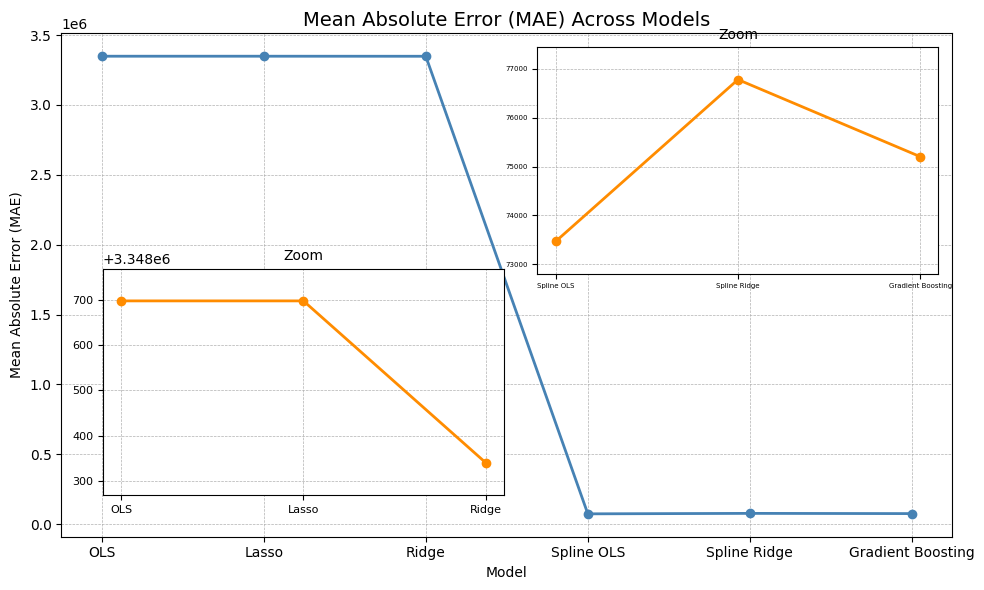

C:\Users\Kian\AppData\Local\Temp\ipykernel_24112\3481519174.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


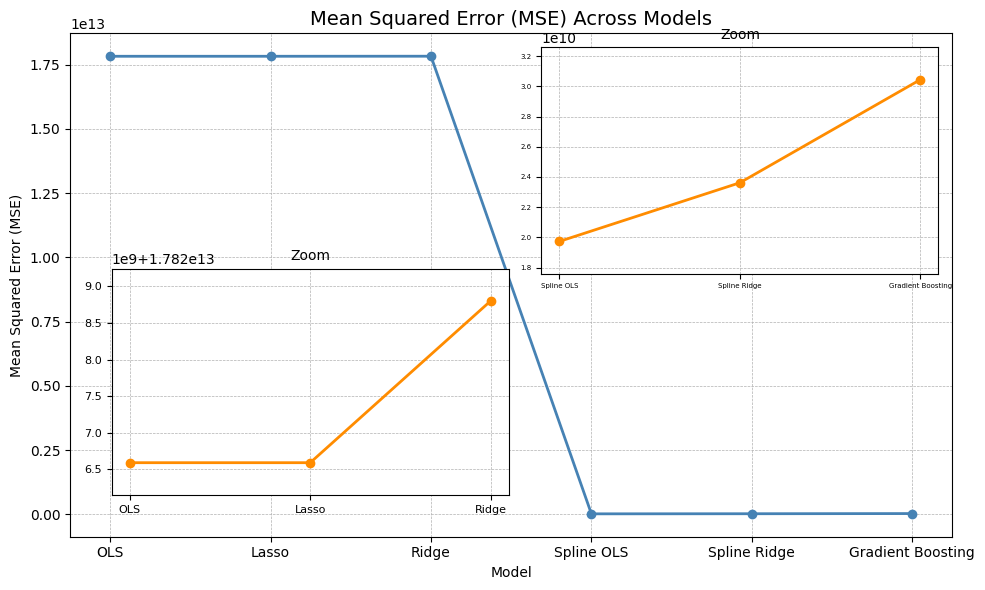

C:\Users\Kian\AppData\Local\Temp\ipykernel_24112\3481519174.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


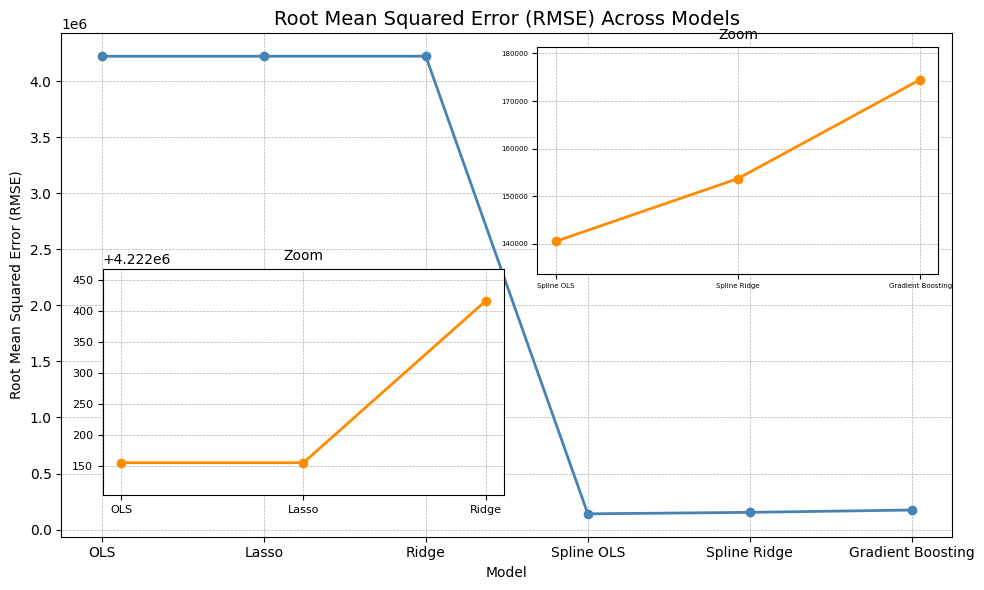

C:\Users\Kian\AppData\Local\Temp\ipykernel_24112\3481519174.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


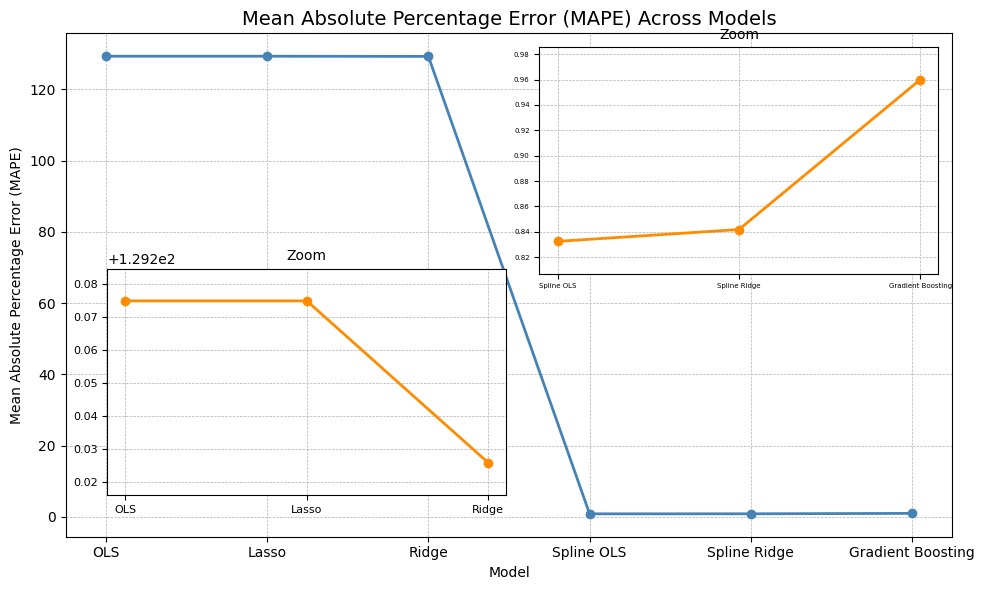

C:\Users\Kian\AppData\Local\Temp\ipykernel_24112\3481519174.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


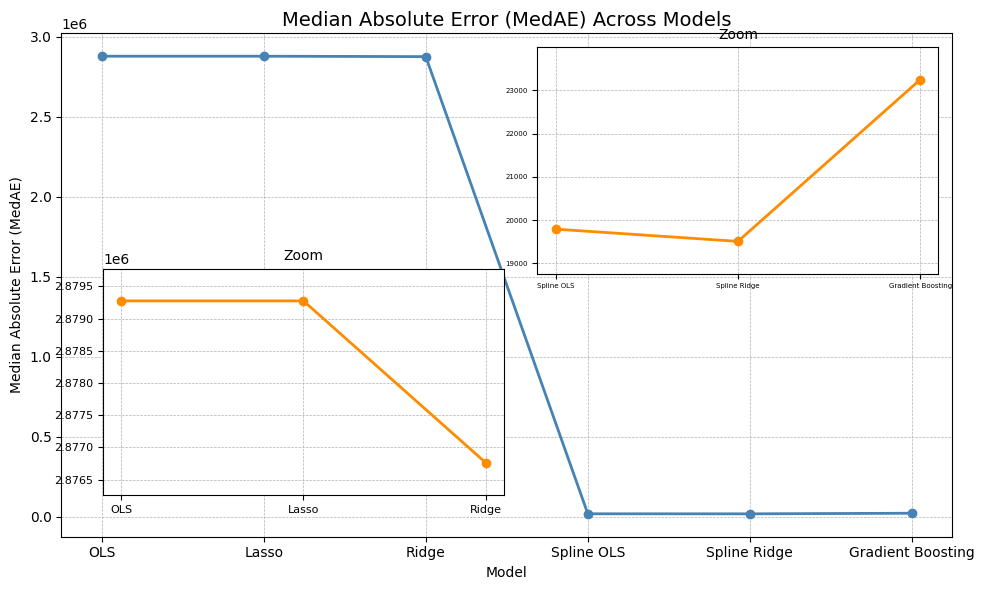

In [14]:
model_names = ['OLS', 'Lasso', 'Ridge', 'Spline OLS' , 'Spline Ridge'  , 'Gradient Boosting']
df_scores = pd.DataFrame(scores, index=model_names)

# Plot with zoom inset
for metric in df_scores.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_names, df_scores[metric], marker='o', linestyle='-', color='steelblue', linewidth=2)
    ax.set_title(f'{metric} Across Models', fontsize=14)
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Inset axes for zoom
    axins = inset_axes(ax, width="45%", height="45%", loc='lower left', borderpad=3)
    axins_last = inset_axes(ax, width="45%", height="45%", loc='upper right', borderpad=1)

    # Focus inset on first 3 models
    zoomed_models = model_names[:3]
    zoomed_models_last = model_names[3:]
    zoomed_values = df_scores.loc[zoomed_models, metric]
    zoomed_values_last = df_scores.loc[zoomed_models_last, metric]
    axins.plot(zoomed_models, zoomed_values, marker='o', linestyle='-', color='darkorange', linewidth=2)
    axins_last.plot(zoomed_models_last, zoomed_values_last, marker='o', linestyle='-', color='darkorange', linewidth=2)
    axins.set_title("Zoom", fontsize=10)
    axins.grid(True, linestyle='--', linewidth=0.5)
    axins_last.set_title("Zoom", fontsize=10)
    axins_last.grid(True, linestyle='--', linewidth=0.5)

    # Match ticks to zoomed values
    axins.set_xticks(zoomed_models)
    axins.tick_params(labelsize=8)
    axins_last.set_xticks(zoomed_models_last)
    axins_last.tick_params(labelsize=5)

    # Set y-limits to zoom tightly around first 3
    margin = (zoomed_values.max() - zoomed_values.min()) * 0.2
    margin_last = (zoomed_values_last.max() - zoomed_values_last.min()) * 0.2
    axins.set_ylim(zoomed_values.min() - margin, zoomed_values.max() + margin)
    axins_last.set_ylim(zoomed_values_last.min() - margin_last, zoomed_values_last.max() + margin_last)

    plt.tight_layout()
    plt.show()